<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/20_2_%D0%A1%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B0%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Обработка текстов с помощью нейронных сетей](https://colab.research.google.com/drive/1tPZPtZsEi4rv4J_4tcOBMDgyUNQDYKCX)
2. Сравнение архитектур нейронных сетей для обработки текста
3. [Предварительно обученные векторные представления](https://colab.research.google.com/drive/1g_dX1XpRY--X6EjFflCC0717p9_9Y1SP)
4. [Домашняя работа](https://colab.research.google.com/drive/1t7rrJV4BSzFF8ZuiUQASkkq8ijzf0IiJ)

В данном уроке мы на практическом примере рассмотрим различные архитектуры нейронных сетей для задачи классификации, на примере прозы русских писателей.

## Задача классификации писателей Русской литературы

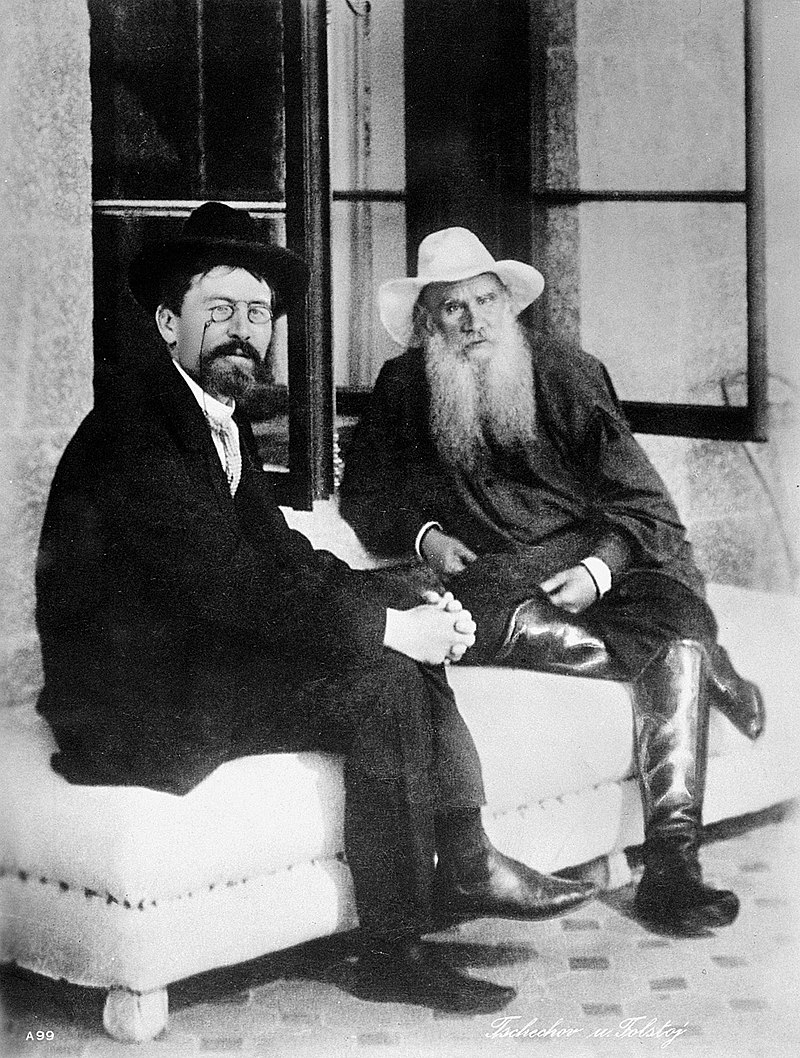

Л.Н. Толстой и А.П. Чехов

### Загрузка данных

Как обычно, процесс обучения начинается с загрузки датасетов и подключения необходимых библиотек.

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/russian_literature.zip

--2024-02-27 10:43:13--  https://storage.yandexcloud.net/academy.ai/russian_literature.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21547079 (21M) [application/x-zip-compressed]
Saving to: ‘russian_literature.zip’

russian_literature. 100%[===================>]  20.55M  5.79MB/s    in 3.8s    

2024-02-27 10:43:18 (5.38 MB/s) - ‘russian_literature.zip’ saved [21547079/21547079]



In [ ]:
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "russian_literature" -d ./dataset

В папке прозы представлены 11 писателей.

In [ ]:
!dir ./dataset/prose

Blok  Bryusov  Chekhov	Dostoevsky  Gogol  Gorky  Herzen  Lermontov  Pushkin  Tolstoy  Turgenev


В папке поэмы представленны 4 писателя.

In [ ]:
!dir ./dataset/poems

Blok  Lermontov  Nekrasov  Pushkin


Пробежимся по папкам и соберем датасеты из всех найденных произведений в обеих папках в один общий словарь, где ключ -  это писатель, а значение - все его произведения одним сплошным текстом.

In [ ]:
# Загрузка необходимых библиотек
import glob # Вспомогательный модуль для работы с файловой системой
import numpy as np
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок


# Выбираем их явно, чтобы список был перед глазами, и отложилось в голове, что имена писателей (точнее их порядковый номер) - это метки
CLASS_LIST=["Dostoevsky", "Tolstoy", "Turgenev", "Chekhov", "Lermontov", "Blok", "Pushkin", "Gogol", "Gorky", "Herzen", "Bryusov", "Nekrasov" ]

all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
  all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
  for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
    with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
                # Загрузка содержимого файла в строку
                text = f.read()

    all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

In [ ]:
# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in all_texts.values())
print(f'Датасет состоит из {total} символов')

Датасет состоит из 38146925 символов


In [ ]:
print('Общая выборка по писателям:')
for author in CLASS_LIST:
    # удобный метод форматирования 2 знака после запятой f'{ВЫРАЖЕНИЕ:.2f}'
    print(f'{author} - {len(all_texts[author])} символов, доля в общей базе: {len(all_texts[author])/total*100 :.2f}%')

Общая выборка по писателям:
Dostoevsky - 11221679 символов, доля в общей базе: 29.42%
Tolstoy - 9392435 символов, доля в общей базе: 24.62%
Turgenev - 2345243 символов, доля в общей базе: 6.15%
Chekhov - 1834330 символов, доля в общей базе: 4.81%
Lermontov - 364382 символов, доля в общей базе: 0.96%
Blok - 604204 символов, доля в общей базе: 1.58%
Pushkin - 1399557 символов, доля в общей базе: 3.67%
Gogol - 2196599 символов, доля в общей базе: 5.76%
Gorky - 4324025 символов, доля в общей базе: 11.34%
Herzen - 1282316 символов, доля в общей базе: 3.36%
Bryusov - 2830897 символов, доля в общей базе: 7.42%
Nekrasov - 351258 символов, доля в общей базе: 0.92%


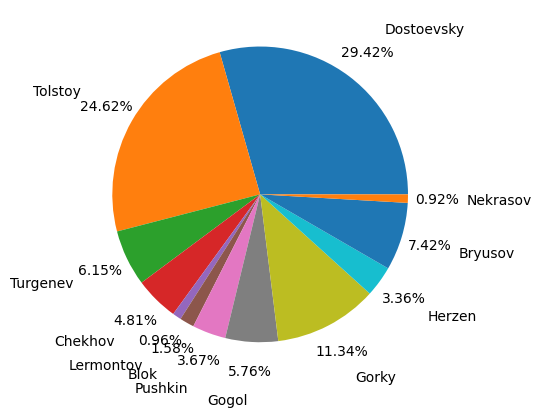

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in all_texts.values()], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

Мы видим, что наш датасет сильно разбалансирован по символам. Мы его сбалансируем немного позже, после токенизации, чтобы не потерять части слов.

### Токенизация

Используем встроенный в Keras токенизатор `Tokenizer` для разбиения текста и построения частотного словаря, со следующими параметрами:

* **num_words**   - объем словаря
* **filters**     - убираемые из текста ненужные символы
* **lower**       - приведение слов к нижнему регистру
* **split**       - разделитель слов, как правило пробел
* **char_level**  - указание разделять по словам, а не по единичным символам
* **oov_token**   - токен для слов, которые не вошли в словарь

In [ ]:
NUM_WORDS = 10000 # Размер словаря

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=NUM_WORDS,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)


# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())
items = list(tokenizer.word_index.items())

In [ ]:
# Вывод нескольких наиболее часто встречающихся слов
print("Первые 10 часто встречающих слова", items[:10])

# Размер словаря может быть больше, чем num_words, однако при преобразовании в последовательности или матрицы учитываются только первые num_words слов
print("Размер словаря:", len(items))

Первые 10 часто встречающих слова [('неизвестное_слово', 1), ('и', 2), ('в', 3), ('не', 4), ('что', 5), ('я', 6), ('на', 7), ('с', 8), ('он', 9), ('как', 10)]
Размер словаря: 249845


Как вы можете увидеть, что слово, которое мы определили в параметре `oov_token` стоит под индексом 1, соответственно, все редкие слова, которые выходят за размер словаря будут помечены индексом 1.

In [ ]:
# Проверка индекса слова в словаре
try:
    print('Вы ввели слово с индексом:', tokenizer.word_index[input('Введите слово (в нижнем регистре): ')])
except:
    print('Такого слова нет в словаре слова нет в словаре')

Введите слово (в нижнем регистре): лошадь
Вы ввели слово с индексом: 586


In [ ]:
seq_train = tokenizer.texts_to_sequences(all_texts.values())

In [ ]:
author = "Pushkin"
cls = CLASS_LIST.index(author)

print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", all_texts[author][:120])
print("Он же в виде последовательности индексов: ", seq_train[cls][:20])

Фрагмент обучающего текста:
В виде оригинального текста:                Александр Пушкин КИРДЖАЛИ ПОВЕСТЬ Кирджали был родом булгар. Кирджали на турецком языке значит витязь, удалец. Настояще
Он же в виде последовательности индексов:  [2097, 3338, 1, 3409, 1, 36, 1, 1, 1, 7, 1, 2652, 415, 1, 1, 3659, 13, 1417, 6, 4]


In [ ]:
# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 5938471 слов


In [ ]:
print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Общая выборка по писателям (по словам):
Dostoevsky - 1779919 слов, доля в общей базе: 29.97%
Tolstoy - 1456418 слов, доля в общей базе: 24.53%
Turgenev - 365152 слов, доля в общей базе: 6.15%
Chekhov - 291031 слов, доля в общей базе: 4.90%
Lermontov - 55465 слов, доля в общей базе: 0.93%
Blok - 89445 слов, доля в общей базе: 1.51%
Pushkin - 214000 слов, доля в общей базе: 3.60%
Gogol - 341263 слов, доля в общей базе: 5.75%
Gorky - 671672 слов, доля в общей базе: 11.31%
Herzen - 190526 слов, доля в общей базе: 3.21%
Bryusov - 430108 слов, доля в общей базе: 7.24%
Nekrasov - 53472 слов, доля в общей базе: 0.90%
Среднее значение слов:  494873.0
Медианное значение слов:  316147.0


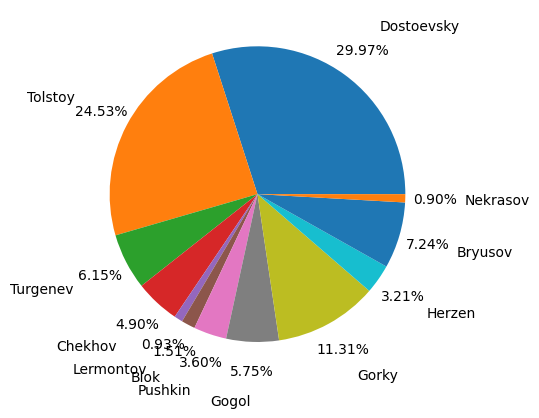

In [ ]:
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

### Балансировка датасета

В идеале каждая выборка должна иметь примерно одинаковое число слов. Это должно предотвратить переобучение в сторону большего класса. Это можно сравнить с обучением ребенка. Представьте, что вы показываете ребенку картинки с "кошками" и неожиданно показали картинку с "собакой". Либо у ребенка будет очень сильное впечатление от того, что есть еще загадочный зверь "собака" и он будем вам ее называть даже тогда, когда видит "кошку", либо, после дальнейшего обучения на картинках с "кошками" совсем забудет про "собаку".

Мы видим, что как по словам, так и по символам наш датасет сильно разбалансирован. Поэтому мы должны избавиться от "выбросов" как в большую, так и меньшую стороны. Для этого уменьшим в выборке число записей по Достоевскому, Толстому Горькому до медианного значения (самого частого в выборке), а писателей, у которых число слов меньше 60% от медианного значения (Некрасова, Лермонтова и Блока), уберем из выборки совсем. Таким образом получим "относительно" сбалансированную выборку, по которой будем обучать нейронную сеть.

Переопределим новый сбалансированный датасет `seq_train_balance` и новые метки к нему `CLASS_LIST_BALANCE`.

In [ ]:
median = int(np.median(mean_list)) # Зафиксировали медианное значение
CLASS_LIST_BALANCE = [] # Сбалансированный набор меток
seq_train_balance = []
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    if len(seq_train[cls]) > median * 0.6:
      seq_train_balance.append(seq_train[cls][:median])
      CLASS_LIST_BALANCE.append(author)


Как вы видите, мы отсекли авторов по числу слов ниже 60% от медианы и привели к медиане с большим числом слов.

In [ ]:
total = sum(len(i) for i in seq_train_balance)

print('Сбалансированная выборка по писателям (по словам):')
mean_list_balance = np.array([])
for author in CLASS_LIST_BALANCE:
    cls = CLASS_LIST_BALANCE.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list_balance = np.append(mean_list_balance, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list_balance.mean()))
print('Медианное значение слов: ', np.median(mean_list_balance))

Сбалансированная выборка по писателям (по словам):
Dostoevsky - 316147 слов, доля в общей базе: 5.32%
Tolstoy - 316147 слов, доля в общей базе: 5.32%
Turgenev - 316147 слов, доля в общей базе: 5.32%
Chekhov - 291031 слов, доля в общей базе: 4.90%
Pushkin - 214000 слов, доля в общей базе: 3.60%
Gogol - 316147 слов, доля в общей базе: 5.32%
Gorky - 316147 слов, доля в общей базе: 5.32%
Herzen - 190526 слов, доля в общей базе: 3.21%
Bryusov - 316147 слов, доля в общей базе: 5.32%
Среднее значение слов:  288049.0
Медианное значение слов:  316147.0


Визализируем на круговой диаграмме распределение по числу слов:

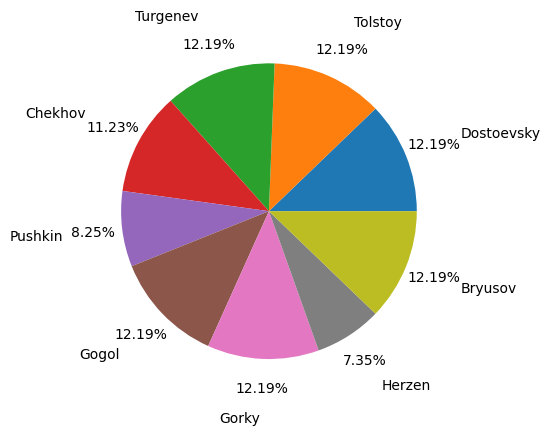

In [ ]:
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance],  # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_BALANCE,            # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

Датасет достаточно сбалансирован и можно переходить к процессу получения конечной тренировочной выборки для обучения.

### Создание обучающей и проверочной выборок методом скользящего окна

На данный момент весь текст представляет собой одну большую последовательность индексов по каждому писателю. В обучающей выборке должно содержаться большое количество небольших примеров, а у нас один большой. Для подачи в нейросеть этот массив необходимо поделить.

Деление  массива на части производится методом "скользящего окна". Для этого задается размер "окна", который определяет число токенов в каждом примере выборки. Например, если размер "окна" равен 10, то каждый пример выборки будет иметь 10 токенов. Смещать "окно" по массиву можно с разным шагом - "шаг окна".

Процесс деления последовательности индексов "скользящим окном":

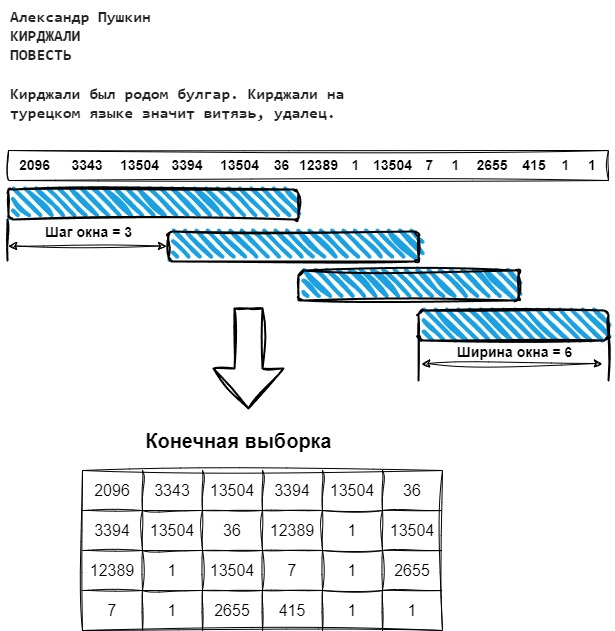

Рис. 1. Создание выборки из сплошного текста методом "скользящего окна"

In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

In [ ]:
# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

Напишем функцию векторизации последовательности и создания конечных выборок:

In [ ]:
def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую сборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_test, y_test =  [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1-test_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_test = seq_split(seq_list[cls][gate_split:], win_size, step)  # последовательность после порога попадет в тестовую выборку

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [utils.to_categorical(cls, len(class_list))] * len(vectors_test)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [ ]:
x_train, y_train, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST_BALANCE, WIN_SIZE, WIN_STEP)

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

Форма входных данных для обучающей выборки: (23248, 1000)
Форма выходных данных (меток) для обучающей выборки: (23248, 9)


In [ ]:
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для тестовой выборки: (2510, 1000)
Форма выходных данных (меток) для тестовой выборки: (2510, 9)


### Вспомогательные функции

Так как мы будем проводить серию экспериментов по обучению разных моделей и визуализации результатов, на одном и том же датасете, то целесообразно написать необходимые вспомогательные функции только один раз, а после вызывать их во всех экспериментах.

In [ ]:
# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


### Эксперимент 1. Bag of Words

#### Модель для Bag of Words

Начнем наши эксперименты с сети на базе Bag Of Words. Сеть будет угадывать одного из писателей, а значит это задача мультиклассовой классификации. Для нее мы уже знаем, что на последнем выходном слое сети необходимо использовать функцию активации `softmax`. В качестве оптимизатора применим `adam` с значениями по умолчанию, функция потерь - категориальная кросс-энтропия.

Используем максимально простую полносвязную модель с 200 нейронами во входном слое и в выходном - по числу классов. Применим обязательно слои регуляризации и нормализации. Как вы увидите на текущем уроке, без регуляризации и нормализации данных результаты совершенно непредсказуемые.

In [ ]:
# Создание последовательной модели нейросети
model_bow = Sequential()
# Входной полносвязный слой
model_bow.add(Dense(200, input_dim=NUM_WORDS, activation="relu"))
# Слой регуляризации Dropout
model_bow.add(Dropout(0.25))
# Слой пакетной нормализации
model_bow.add(BatchNormalization())
# Выходной полносвязный слой
model_bow.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

# Компиляция модели
model_bow.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Вывод модели
model_bow.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               2000200   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 batch_normalization (Batch  (None, 200)               800       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 9)                 1809      
                                                                 
Total params: 2002809 (7.64 MB)
Trainable params: 2002409 (7.64 MB)
Non-trainable params: 400 (1.56 KB)
_________________________________________________________________


Сформируем выборку в виде разреженных матриц (bag of words):

In [ ]:
# На входе sequences_to_matrix() ожидает список, поэтому приведем тип выборки к списку с помощью tolist()
x_train_bow = tokenizer.sequences_to_matrix(x_train.tolist())

x_test_bow = tokenizer.sequences_to_matrix(x_test.tolist())

print(f'Обучающая выборка в виде разряженной матрицы Bag of Words: {x_train_bow.shape}')
print(f'Проверочная выборка в виде разряженной матрицы Bag of Words: {x_test_bow.shape}')

Обучающая выборка в виде разряженной матрицы Bag of Words: (23248, 10000)
Проверочная выборка в виде разряженной матрицы Bag of Words: (2510, 10000)


In [ ]:
# Обучение модели
history = model_bow.fit(
    x_train_bow,
    y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/30
164/164 [==============================] - 5s 10ms/step - loss: 0.0779 - accuracy: 0.9787 - val_loss: 0.8279 - val_accuracy: 0.7720
Epoch 2/30
164/164 [==============================] - 1s 7ms/step - loss: 9.7871e-04 - accuracy: 1.0000 - val_loss: 0.6901 - val_accuracy: 0.7867
Epoch 3/30
164/164 [==============================] - 1s 9ms/step - loss: 4.9816e-04 - accuracy: 1.0000 - val_loss: 0.6484 - val_accuracy: 0.7974
Epoch 4/30
164/164 [==============================] - 1s 7ms/step - loss: 3.2208e-04 - accuracy: 1.0000 - val_loss: 0.6549 - val_accuracy: 0.7935
Epoch 5/30
164/164 [==============================] - 1s 7ms/step - loss: 2.1796e-04 - accuracy: 1.0000 - val_loss: 0.6534 - val_accuracy: 0.7927
Epoch 6/30
164/164 [==============================] - 1s 6ms/step - loss: 1.6987e-04 - accuracy: 1.0000 - val_loss: 0.6545 - val_accuracy: 0.7914
Epoch 7/30
164/164 [==============================] - 1s 6ms/step - loss: 1.3047e-04 - accuracy: 1.0000 - val_loss: 0.6688 - va

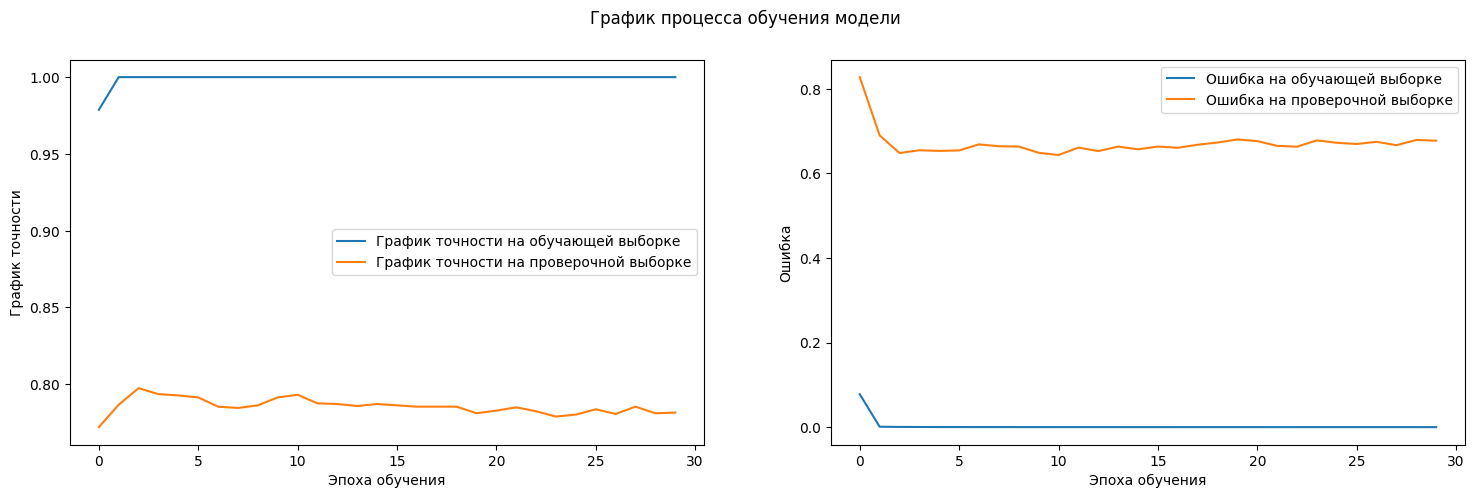

In [ ]:
show_plot(history)

79/79 [==============================] - 0s 2ms/step


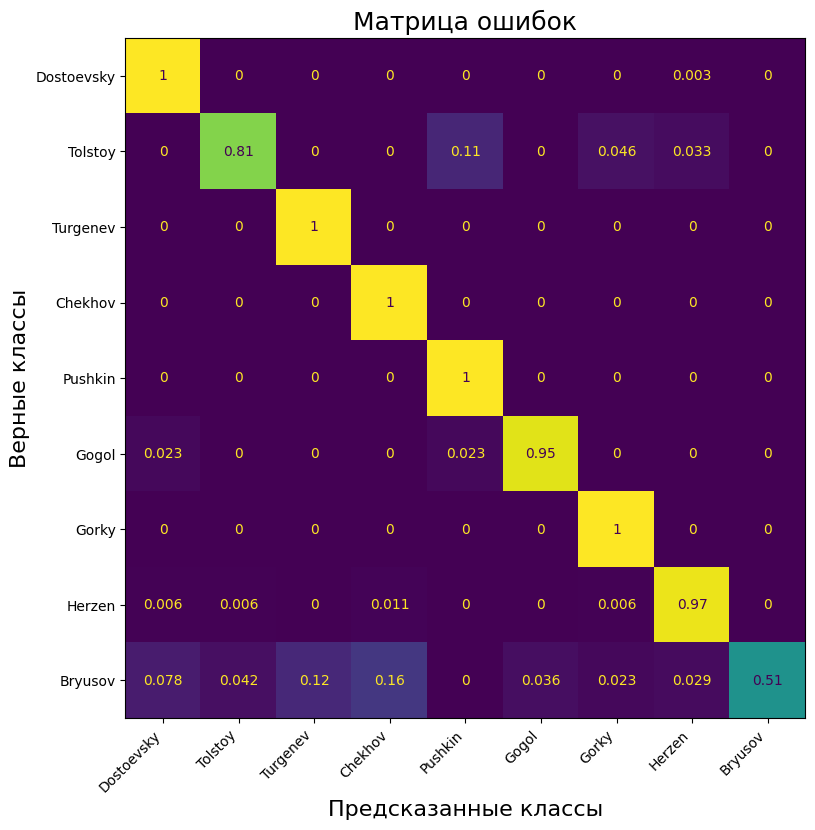


Средняя точность распознавания:  92%


In [ ]:
y_pred = model_bow.predict(x_test_bow)

show_confusion_matrix(y_test, y_pred, CLASS_LIST_BALANCE)

#### Выводы по модели Bag of Words

Мы видим, что уже на второй эпохе обучения модель показывает точность (долю верных ответов) в 100% и больше не меняется. На проверочной точность продолжает расти, а ошибка падает. Мы получили результат точности близкий к 90% на проверочной выборке.

Также мы построили матрицу ошибки, которая позволяет нам проанализировать наш датасет. Чтобы ее построить мы "загнали" в нашу модель всю тестовую выборку и сравнили с ожидаемыми метками. Если модель угадывала значение, то результат отражался на диагонали матрицы, если нет - то отображались в соответствующей ячейке. По оси Х (предсказанные классы) - то что получили в `y_pred`, а по оси Y (верные классы), соответствуют меткам `y_test`. Таким образом матрица отражает различия между `y_pred` и `y_test`.

Диагональ матрицы показывает насколько наша модель хорошо работает. Если сложить все значения по диагонали и разделить на число классов, то мы получим среднюю точность распознавания на тестовой выборке. В данном случае результат вполне хороший - 92% на тестовой выборке.

Значение '1' на диагонали матрицы означает, что все примеры тестовый выборки данного класса были правильно классифицированы моделью.

По матрице можно сделать вывод, что наша модель все время путает Брюсова. В 16% она решила, что это Чехов, в 12%, что это Тургенев. Единственное, что модель точно "знает", что Брюсов - это не Пушкин! А вот в 11% случаев модель решила, что Толстой - это Пушкин!

Вы можете проверить, что если исключить из датасета Брюсова, и обучить модель снова, то точность на тестовой выборке превысит 96%.

### Эксперимент 2. Embedding без регуляризации

Создадим простую сеть без использования слоев нормализации и регуляризации, которые рекомендуется использовать всегда при работе с текстом. И посмотрим к чему это приведет.

In [ ]:
#Создаём сеть с Embedding слоем
model_embedding = Sequential()
model_embedding.add(Embedding(NUM_WORDS, 200, input_length=WIN_SIZE))
model_embedding.add(Flatten())
model_embedding.add(Dense(200, activation="relu"))
model_embedding.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))
# Компиляция модели
model_embedding.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Вывод модели
model_embedding.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 200)         2000000   
                                                                 
 flatten (Flatten)           (None, 200000)            0         
                                                                 
 dense_2 (Dense)             (None, 200)               40000200  
                                                                 
 dense_3 (Dense)             (None, 9)                 1809      
                                                                 
Total params: 42002009 (160.22 MB)
Trainable params: 42002009 (160.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Слой `Embedding` получает на входе двумерный тензор с целыми числами и с формой
`(образцы, длина последовательности)`, каждый элемент которого является последовательностью целых чисел.

На выходе `Embedding` возвращает трехмерный тензор с вещественными числами и с формой `(образцы, длина последовательности, размерность векторного представления)`.

Поэтому нам необходимо между слоями `Embedding` и `Dense` использовать слой `Flatten`, который развернет трехмерный тензор на выходе `Embedding` в одномерный для передачи в `Dense`.

Обучим модель:

In [ ]:
# Обучение модели
history = model_embedding.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/30
164/164 [==============================] - 22s 128ms/step - loss: 0.5072 - accuracy: 0.8333 - val_loss: 1.3262 - val_accuracy: 0.5217
Epoch 2/30
164/164 [==============================] - 12s 77ms/step - loss: 5.3117e-04 - accuracy: 1.0000 - val_loss: 1.6113 - val_accuracy: 0.4318
Epoch 3/30
164/164 [==============================] - 8s 46ms/step - loss: 3.0334e-04 - accuracy: 1.0000 - val_loss: 1.6299 - val_accuracy: 0.4280
Epoch 4/30
164/164 [==============================] - 6s 36ms/step - loss: 1.9511e-04 - accuracy: 1.0000 - val_loss: 1.6163 - val_accuracy: 0.4344
Epoch 5/30
164/164 [==============================] - 7s 42ms/step - loss: 1.3498e-04 - accuracy: 1.0000 - val_loss: 1.6662 - val_accuracy: 0.4258
Epoch 6/30
164/164 [==============================] - 5s 30ms/step - loss: 9.8043e-05 - accuracy: 1.0000 - val_loss: 1.7028 - val_accuracy: 0.4172
Epoch 7/30
164/164 [==============================] - 5s 30ms/step - loss: 7.3906e-05 - accuracy: 1.0000 - val_loss: 1.

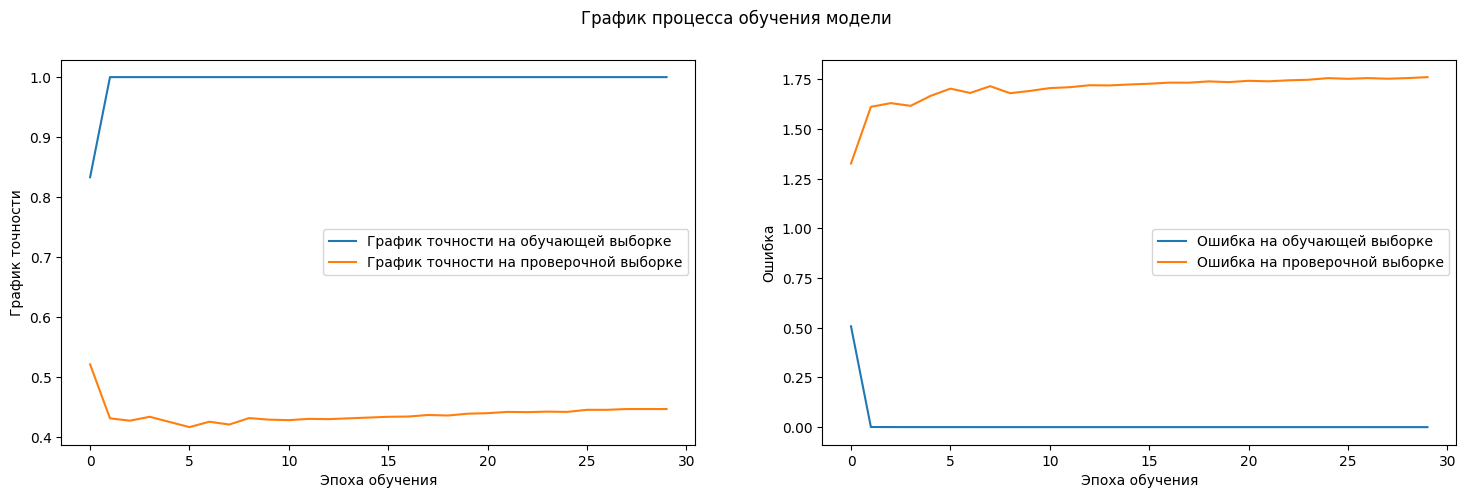

In [ ]:
show_plot(history)

79/79 [==============================] - 0s 3ms/step


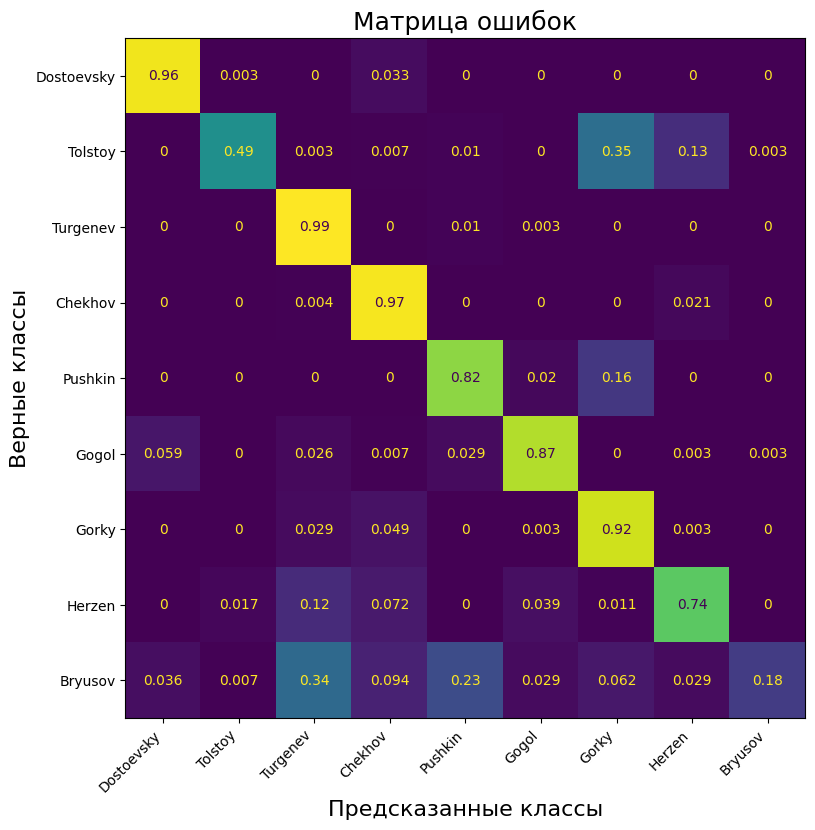


Средняя точность распознавания:  77%


In [ ]:
y_pred = model_embedding.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST_BALANCE)

Обучение модели с использование Embedding довольно странно себя проявило. Уже на второй эпохе, на обучающей выборке, точность достигла максимума, а функция ошибки - минимума. На проверочной выборке максимум точности был на первой эпохе и снижался по мере обучения. Функция ошибки росла по мере обучения. Однако средняя точность на тестовой выборке показала себя на уровне 77%. Результат неожиданный!   

### Эксперимент 3. Embedding с регуляризацией

В этом примере на выходе из `Embedding` мы применим пространственную одномерную версию `Dropout`, а именно `SpatialDropout1D`.

Этот слой выполняет ту же функцию, что и `Dropout`, однако он удаляет целые одномерные последовательности связей вместо отдельных элементов. Если соседние элементы  сильно коррелированы (как это обычно бывает в ранних слоях свертки), то `Dropout` не упорядочит активации и просто приведет к снижению скорости обучения. В этом случае рекомендуется использовать `SpatialDropout1D`. Не бойтесь экспериментировать, пробуйте разные варианты. Сравнивайте не только метрики, например, точности, но и скорости обучения.

In [ ]:
#Создаём сеть с Embedding слоем
model_embedding_reg = Sequential()
model_embedding_reg.add(Embedding(NUM_WORDS, 200, input_length=WIN_SIZE))
model_embedding_reg.add(SpatialDropout1D(0.2))
model_embedding_reg.add(Flatten())
model_embedding_reg.add(BatchNormalization())
model_embedding_reg.add(Dense(200, activation="relu"))
model_embedding_reg.add(Dropout(0.2))
model_embedding_reg.add(BatchNormalization())
model_embedding_reg.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

# Компиляция модели
model_embedding_reg.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Вывод модели
model_embedding_reg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 200)         2000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 1000, 200)         0         
 Dropout1D)                                                      
                                                                 
 flatten_1 (Flatten)         (None, 200000)            0         
                                                                 
 batch_normalization_1 (Bat  (None, 200000)            800000    
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 200)               40000200  
                                                                 
 dropout_1 (Dropout)         (None, 200)              

In [ ]:
# Обучение модели
history = model_embedding_reg.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/50
164/164 [==============================] - 18s 94ms/step - loss: 0.9268 - accuracy: 0.7519 - val_loss: 2.8640 - val_accuracy: 0.0000e+00
Epoch 2/50
164/164 [==============================] - 12s 70ms/step - loss: 0.0136 - accuracy: 0.9999 - val_loss: 2.6941 - val_accuracy: 0.0284
Epoch 3/50
164/164 [==============================] - 8s 51ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 2.1911 - val_accuracy: 0.1583
Epoch 4/50
164/164 [==============================] - 8s 50ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.9177 - val_accuracy: 0.2649
Epoch 5/50
164/164 [==============================] - 8s 47ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.8698 - val_accuracy: 0.2998
Epoch 6/50
164/164 [==============================] - 8s 48ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.8563 - val_accuracy: 0.3131
Epoch 7/50
164/164 [==============================] - 8s 46ms/step - loss: 7.6675e-04 - accuracy: 1.0000 - val_loss: 1.8507 - val_accura

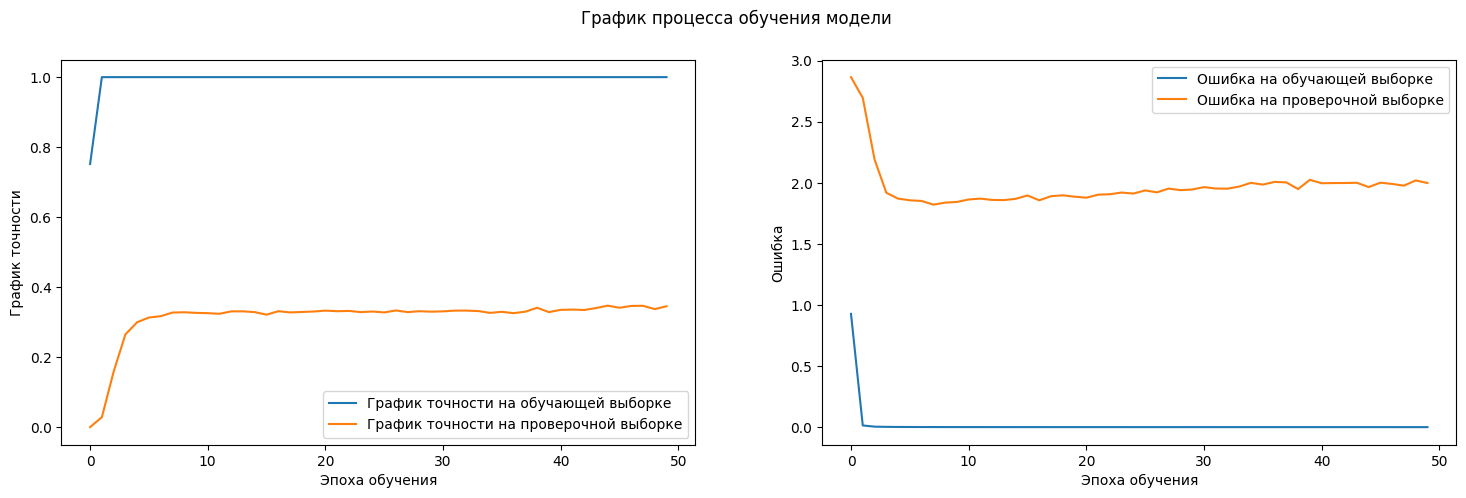

In [ ]:
show_plot(history)

79/79 [==============================] - 1s 7ms/step


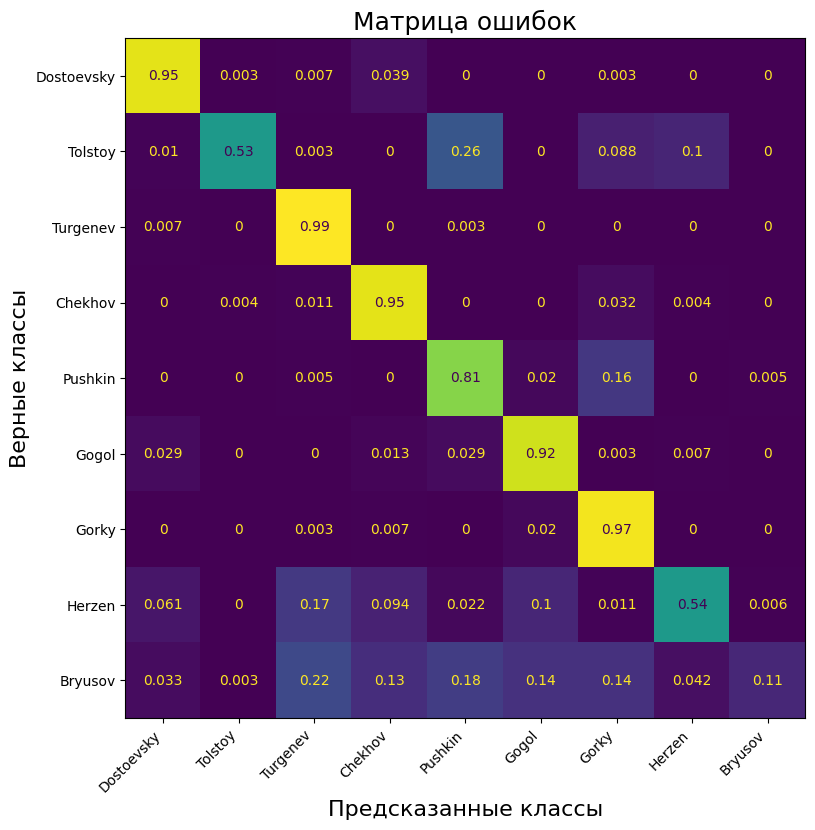


Средняя точность распознавания:  75%


In [ ]:
y_pred = model_embedding_reg.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST_BALANCE)

### Выводы по модели Embedding

Во всех экспериментах с Embedding мы получили неудовлетворительные результаты на проверочной выборке, хотя и средняя точность распознания около 75%. Причем регуляризация привела к снижению средней точности на тестовой выборке.  
Результат сильно уступает модели Bag Of Words. Однако у "мешка слов" есть большой минус - он требует большой оперативной памяти. Но это не значит, что если какой-то метод отработал хуже в данной ситуации, то он плохой. Просто мы его применили не по назначению. Embedding особенно хорош, если его предварительно обучить. Чем мы и займемся в следующем [Блокноте](https://colab.research.google.com/drive/1g_dX1XpRY--X6EjFflCC0717p9_9Y1SP).